In [1]:
%load_ext autoreload
%autoreload 2

import copy
import json
# import logging
import math
import multiprocessing
import os
import statistics
import time

import sys
sys.path.insert(0, "/Users/rico.meinl/Desktop/BACHELOR_THESIS/instacart2vec/source")

from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import argsort
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

from source.item2vec_recommender import Item2VecRecommender
from source.item2vec_embeddings import Item2VecEmbeddings
from source.data_loader import DataLoader

### JUST FOR TEST
from itertools import permutations
from scipy.sparse import dok_matrix, csr_matrix
# from baseline_recommender import ItemCoCountRecommender
from source.utils import convert_size

# logging.basicConfig(
#      format="%(levelname)s - %(asctime)s: %(message)s",
#      datefmt="%H:%M:%S",
#      level=logging.INFO,
# )

## Load Data

In [2]:
small = ""
# small = "small_"
algorithm = "meta-item2vec"

In [3]:
data_loader = DataLoader(algorithm=algorithm,
                         small_data=(small!=""),
                         with_meta=True,
                         with_user=False,
                         use_file_iterator=True)

With Metadata: True
With User: False
Loading data...
Creating file to iterate for meta-item2vec in sentences/meta-item2vec/train.txt


In [ ]:
data_loader = load_data(small_data=(small!=""))

In [ ]:
train_data = data_loader["train"]
validation_data = data_loader["validation"]
test_data = data_loader["test"]
item_metadata = data_loader["metadata"]

In [ ]:
# # Create product key conversion if not exists
product_key_conversion = get_product_key_conversion(item_metadata)
print(product_key_to_meta(product_key_conversion, "1"))
print(product_key_to_name(product_key_conversion, "1"))

### Adding Product Metadata (only Category for now) to **train** sentences

In [ ]:
def get_category_key_conversion(metadata) -> dict:
    category_key_conversion = {}

    for index, row in metadata.iterrows():
        category_key_conversion.setdefault(str(row["department"]), f'category_{row["department_id"]}')
        
    return category_key_conversion

def category_to_key(category):
    assert category_key_conversion
    return category_key_conversion.get(category, category)

In [ ]:
# Create category key conversion if not exists
category_key_conversion = get_category_key_conversion(item_metadata)
print(category_to_key("dairy eggs"))

In [ ]:
def add_product_categories(transaction_data):
    for index, transaction in enumerate(transaction_data):
        items_with_categories = []

        # user id is always first in list, then all the purchased items
        items_with_categories.append(transaction[0])

        items_without_user = copy.deepcopy(transaction[1:])

        # add product categories to the item list
        for item in items_without_user:
            category_key = category_to_key(data_loader.product_key_conversion.get(item).split("\t")[1])
            items_with_categories.append(item)
            items_with_categories.append(category_key)

        transaction_data[index] = items_with_categories

    return transaction_data

In [ ]:
train = add_product_categories(data_loader.train_data)

In [ ]:
# test_items = train_data[0][1:]

def add_product_categories(items):
    items_with_categories = []
    
    # user id is always first in list, then all the purchased items
    items_with_categories.append(items[0])
    
    items_without_user = copy.deepcopy(items[1:])
    
    # add product categories to the item list
    for item in items_without_user:
        category_key = category_to_key(data_loader.product_key_conversion.get(item).split("\t")[1])
        items_with_categories.append(item)
        items_with_categories.append(category_key)
        
    return items_with_categories

# print(test_items)
# print(add_product_categories(test_items))

In [ ]:
def create_sentences(data, stage, is_np_array=False, overwrite=True):
    # Build train set
    filepath = f"sentences/{algorithm}/{stage}.txt"
    if overwrite:
        print(
            f"Creating sentences for the {stage} stage for item2vec in {filepath}"
        )
        with open(filepath, "w") as file:
            if is_np_array:
                for transaction in data:
                    # user id is always first in list, then all the purchased items
                    user_id = transaction[0]
                    # add product categories to the item list
                    items = add_product_categories(transaction[1:])
                    if len(items) > 0:
                        file.write(" ".join(map(str, items)) + "\n")
            else:
                for i, row in data.iterrows():
                    file.write(' '.join(map(str, row["product_id"])) + "\n")
                
    return filepath

In [ ]:
class SentenceIterator(object):
    def __init__(self, sentences_filepath):
        self.sentences_filepath = sentences_filepath
                    
    def __iter__(self):
        assert os.path.exists(self.sentences_filepath)
        for line in open(self.sentences_filepath):
            yield line.split()

In [ ]:
# train_sentences_path = create_sentences(train_data, "train", overwrite=False)
train_sentences_path = create_sentences(train_data, f"{small}train", is_np_array=True, overwrite=True)
train_sentences = SentenceIterator(sentences_filepath=train_sentences_path)

## Training Embeddings

In [ ]:
def get_filtered_model_vectors(model, verbose=False):
    to_trim = [(index, item_key) for index, item_key in enumerate(model.wv.index2word) if item_key.startswith('category_')]
    indices_to_trim, words_to_trim = list(zip(*to_trim))
    indices_to_trim = list(indices_to_trim)
    words_to_trim = list(words_to_trim)
    
    if verbose:
        print(f"Removing {len(words_to_trim)} categories from the model: {words_to_trim}")

    for word in words_to_trim:
        del model.wv.vocab[word]

    embedding_vectors = np.delete(model.wv.vectors, indices_to_trim, axis=0)
    context_vectors = np.delete(model.trainables.syn1neg, indices_to_trim, axis=0)

    for index in sorted(indices_to_trim, reverse=True):
        del(model.wv.index2word[index])
        
    test_index2word = set(model.wv.index2word)
    for word in words_to_trim:
        assert word not in model.wv.vocab
        assert word not in test_index2word
        
    return model, embedding_vectors, context_vectors

In [ ]:
def train_model(
        train_data,
        epochs,
        embedding_size,
        window_size,
        ns_exponent,
        number_of_negative_samples,
        min_count,
        sample,
        save=False,
    ):

        model = Word2Vec(
            train_data,
            sg=1,
            size=embedding_size,
            window=window_size,
            min_count=min_count,
            compute_loss=True,
            workers=multiprocessing.cpu_count(),
            hs=0,
            sample=sample,
            negative=number_of_negative_samples,
            ns_exponent=ns_exponent,
            iter=epochs
        )

        # getting the training loss value
        training_loss = model.get_latest_training_loss()
        print(f"Latest training loss: {training_loss}")
        
        model.init_sims(replace=True)

        if save:
            model.save(f"models/{algorithm}/embeddings.model")
            print("Model Saved")
            
        return model

In [4]:
embeddings = Item2VecEmbeddings(algorithm=algorithm,
                                product_key_conversion=data_loader.product_key_conversion,
                                with_meta=True,
                                with_user=False)

embeddings.load_model(model_path=f"models/{algorithm}/embeddings_categories_aisles.model")

# embeddings.train_model(
#                     data_loader.train_data_iterator,
#                     epochs=15,
#                     embedding_size=128,
#                     window_size=5, # 100,
#                     min_count=10,
#                     number_of_negative_samples=7,
#                     sample=0.01,
#                     ns_exponent=0.5,
#                     save=False,
#                 )

# model = train_model(
#                  train_sentences,
#                  epochs=1,
#                  embedding_size=128,
#                  window_size=200, # using 100 * metadata added. In this case I only added category which doubles the items in each sentence
#                  min_count=10,
#                  number_of_negative_samples=7,
#                  sample=0.01,
#                  ns_exponent=0.5,
#                  save=True
#              )

# model = Word2Vec.load(f"models/{algorithm}/embeddings.model")

Loading Word2Vec model...
Removing 155 categories from the model: ['category_4', 'category_16', 'aisle_24', 'aisle_83', 'category_19', 'category_7', 'category_1', 'category_13', 'aisle_123', 'aisle_120', 'category_3', 'category_15', 'category_20', 'aisle_21', 'aisle_84', 'category_9', 'aisle_115', 'category_17', 'aisle_107', 'category_14', 'category_12', 'aisle_91', 'aisle_112', 'aisle_31', 'aisle_116', 'aisle_37', 'aisle_3', 'aisle_78', 'aisle_86', 'category_11', 'category_18', 'aisle_96', 'aisle_92', 'aisle_38', 'aisle_16', 'aisle_121', 'aisle_67', 'aisle_77', 'aisle_69', 'aisle_98', 'aisle_17', 'aisle_53', 'aisle_108', 'aisle_117', 'aisle_106', 'aisle_45', 'aisle_81', 'aisle_88', 'aisle_32', 'aisle_59', 'category_6', 'aisle_131', 'aisle_36', 'aisle_93', 'aisle_94', 'aisle_19', 'aisle_54', 'aisle_61', 'aisle_52', 'aisle_72', 'aisle_9', 'aisle_104', 'aisle_26', 'aisle_4', 'aisle_129', 'aisle_128', 'aisle_50', 'aisle_66', 'aisle_23', 'aisle_79', 'aisle_130', 'category_5', 'aisle_63', '

In [ ]:
model, embedding_vectors, context_vectors = get_filtered_model_vectors(model)

In [ ]:
# Create a matrix filled with embeddings of all items considered
mapping = {item_key: index for index, item_key in enumerate(model.wv.index2word)}
mapping_back = {index: item_key for item_key, index in mapping.items()}
embedding = [model.wv[key] for key in mapping.keys()]

assert len(embedding) == len(mapping) == len(embedding_vectors) == len(context_vectors)

# Make sure to only include the product embeddings in the evaluation. Mapping of key to index (using index to filter input and context vectors for model)
# embedding = [model.wv[key] for key in model.wv.vocab.keys() if key.startswith('product_')]
# context_vectors = [vector for vector in model.trainables.syn1neg]
# mapping = {key: i for i, key in enumerate(model.wv.vocab.keys()) if key in product_keys}
# mapping_back = {v: k for k, v in mapping.items()}

In [ ]:
y_category_list = []
y_aisle_list = []
        
for key in mapping.keys():
    y_category_list.append(product_key_to_meta(product_key_conversion, key).split("\t")[1])
    y_aisle_list.append(product_key_to_meta(product_key_conversion, key).split("\t")[2])

assert len(embedding) == len(y_category_list) == len(y_aisle_list)
print(f"Number of Categories: {len(set(y_category_list))}")
print(f"Number of Aisles: {len(set(y_aisle_list))}")

In [ ]:
y_category_list[:5]

In [ ]:
y_aisle_list[:5]

## Category and Aisle Prediction

In [ ]:
def predict_labels(classifier, x, y, test_size=0.5):
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=0)

    classifier.fit(x_train, y_train)
    y_predictions = classifier.predict(x_test)

    # accuracy = round(accuracy_score(y_predictions, y_test), 3)
    # precision = round(precision_score(y_predictions, y_test, average="weighted"), 3)
    # recall = round(recall_score(y_predictions, y_test, average="weighted"), 3)
    f1_micro = round(f1_score(y_predictions, y_test, average="micro"), 4)
    f1_macro = round(f1_score(y_predictions, y_test, average="macro"), 4)
    f1_weighted = round(f1_score(y_predictions, y_test, average="weighted"), 4)
    f1_per_class = f1_score(y_predictions, y_test, average=None)

    return f1_micro, f1_macro, f1_weighted, f1_per_class

In [ ]:
k_neighbors = 10
k_neighbors_classifier = KNeighborsClassifier(n_neighbors=k_neighbors, n_jobs=-1)

In [ ]:
category_f1, aisle_f1 = embeddings.evaluate_embeddings(k_neighbors=10)

# category_f1 = predict_labels(classifier=k_neighbors_classifier, x=embedding, y=y_category_list)
# aisle_f1 = predict_labels(classifier=k_neighbors_classifier, x=embedding, y=y_aisle_list)

# print(f"Micro: {category_f1[0]}, Macro: {category_f1[1]}, Weighted: {category_f1[2]}")
# print(f"Micro: {aisle_f1[0]}, Macro: {aisle_f1[1]}, Weighted: {aisle_f1[2]}")

In [ ]:
# Small Data
# 5 epochs (64 dims)
# Micro: 0.5179, Macro: 0.3083, Weighted: 0.567
# Micro: 0.3111, Macro: 0.1314, Weighted: 0.367

# # 5 epochs (32 dims)
# Micro: 0.559, Macro: 0.3312, Weighted: 0.6019
# Micro: 0.3231, Macro: 0.1447, Weighted: 0.3697

# 5 epochs (128 dims)
# Micro: 0.4068, Macro: 0.1842, Weighted: 0.4701
# Micro: 0.2479, Macro: 0.1, Weighted: 0.3145

# 5 epochs (128 dims) using model.init_sims()
# Micro: 0.5846, Macro: 0.3872, Weighted: 0.6137
# Micro: 0.3487, Macro: 0.1544, Weighted: 0.3917

# 5 epochs (256 dims)
# Micro: 0.3316, Macro: 0.1322, Weighted: 0.4191
# Micro: 0.2017, Macro: 0.0816, Weighted: 0.265

# 15 epochs
# Micro: 0.4803, Macro: 0.2815, Weighted: 0.5265
# Micro: 0.2974, Macro: 0.1203, Weighted: 0.3548

# 25 epochs
# Micro: 0.4855, Macro: 0.2555, Weighted: 0.5369
# Micro: 0.3043, Macro: 0.1338, Weighted: 0.3557

# 100 epochs
# Micro: 0.4684, Macro: 0.2413, Weighted: 0.5284
# Micro: 0.2923, Macro: 0.1236, Weighted: 0.3459

## Meta-Item2Vec Recommender

In [ ]:
# As the additional number of categories is so small, we don't care to filter them in advance, we just filter them during prediction
metaitem2vec_recommender = Item2VecRecommender(algorithm="meta-item2vec", 
                                               item_key_mapping=embeddings.mapping,
                                               user_item_frequency=data_loader.user_item_frequency,
                                               embedding_vectors=embeddings.embedding_vectors, 
                                               context_vectors=embeddings.context_vectors)
print(metaitem2vec_recommender.context_vectors.shape)
print(metaitem2vec_recommender.embedding_vectors.shape)

# As the additional number of categories is so small, we don't care to filter them in advance, we just filter them during prediction
# metaitem2vec_recommender = Item2VecRecommender(algorithm="meta-item2vec", 
#                                                item_key_mapping=mapping, 
#                                                user_item_frequency=user_item_frequency,
#                                                embedding_vectors=embedding_vectors, 
#                                                context_vectors=context_vectors)
# print(metaitem2vec_recommender.context_vectors.shape)
# print(metaitem2vec_recommender.embedding_vectors.shape)

# TEST START

In [ ]:
def predict_items(recommender, user_id, given_items):
        candidate_list = []
        # map the items word to its index
        target_items = [recommender.item_key_mapping[key] if (isinstance(key, str) and key.startswith("product")) else key for key in given_items]
        # slice the word vectors array to only keep the relevant items
        item_embeddings = recommender.embedding_vectors[target_items]

        mean_basket_vector = np.mean(item_embeddings, 0)

        # complementary items need to be calculated via dot product not cosine similarity
        distances = np.dot(recommender.context_vectors, mean_basket_vector)
        # distances = np.dot(recommender.embedding_vectors, mean_basket_vector)

        # sorted distances from largest to smallest, sort only when we're not in evaluation to save time
        # candidate_indices = np.arange(0, len(distances))

        # to get the distance: float(dists[item])
        # candidate_list = [(recommender.reverse_item_key_mapping[index], float(distances[index])) for index in candidate_indices]
                    
        # if self.predict_k < self.n_items do candidate_list[:predict_k]; otherwise its equal to self.n_items and I can apply it to all
        #ranked_candidates = {product_id: score for (product_id, score) in candidate_list}

        return distances # ranked_candidates

In [ ]:
def evaluate_transaction(recommender, user_id, given_items, test_items, k=20):
        # get the predicted items and their scores
        item_scores = predict_items(recommender, user_id=user_id, given_items=given_items)
        # create a list of item scores
        # predicted_item_scores = np.array(list(item_scores.values()))
        # create a mapping for items to index in the scores list
        # item_indices = {key: index for index, key in enumerate(item_scores.keys())}
        
        
        # separate the target items from the other items
        negative_index = np.ones(recommender.n_items)
        mask_items = [recommender.item_key_mapping[key] for key in test_items]
        negative_index[mask_items] = 0
        target_item_scores = item_scores[mask_items]
        negative_items = item_scores[negative_index>0]
        
        # calculate the auc and ndcg
        n_negative = len(negative_items)
        false_predictions = (target_item_scores.reshape(1, len(target_item_scores)) <= negative_items.reshape(n_negative, 1)).sum(axis=0)
        auc = (n_negative - false_predictions) / n_negative
        ndcg = 1.0/np.log2(2 + false_predictions)
        
        # Precision and Recall @ K
        top_k_items = argsort(item_scores, topn=k, reverse=True)
        recall_at_k = recommender.recall(mask_items, top_k_items, k=k)
        precision_at_k = recommender.precision(mask_items, top_k_items, k=k)
        
        return auc, ndcg, recall_at_k, precision_at_k

In [ ]:
def evaluate(recommender, test_transactions, k=10, within_basket=True):
        start_time = time.time()
        
        # more efficient than interating over numpy array
        test_transactions = list(test_transactions)
        metrics = []
        min_transaction_items = 2
        # after removing transactions with less than MIN_TRANSACTION_ITEMS
        actual_transaction_length = len(test_transactions)
        print(f"{actual_transaction_length} transactions to evaluate.")
        
        for test_transaction in test_transactions:
            # user id is always first in list, then all the purchased items
            user_id = test_transaction[0]
            items = [item for item in test_transaction[1:] if item in recommender.item_key_mapping]
            
            if within_basket:
                if len(items) < min_transaction_items:
                    actual_transaction_length -= 1
                    continue

                half = math.ceil(len(items) / 2)
                given_item_ids = items[:half] # given items
                hold_out_item_ids = items[half:] # test items
            else:
                if user_id not in recommender.user_item_frequency or len(items) < min_transaction_items:
                    actual_transaction_length -= 1
                    continue
                given_item_ids = list(recommender.user_item_frequency[user_id].keys())
                given_item_ids = [item for item in given_item_ids if item in recommender.item_key_mapping]
                hold_out_item_ids = items
            
            _auc, _ndcg, _recall_at_k, _precision_at_k = evaluate_transaction(recommender, 
                                                                              user_id=user_id, 
                                                                              given_items=given_item_ids, 
                                                                              test_items=hold_out_item_ids,
                                                                              k=k)
            metrics.append([_auc.mean(), _ndcg.mean(), _recall_at_k, _precision_at_k])

        actual_transaction_length = len(metrics)
        metrics = np.array(metrics).mean(axis=0)
        auc = round(metrics[0], 4)
        ndcg = round(metrics[1], 4)
        recall_at_k = round(metrics[2], 4)
        precision_at_k = round(metrics[3], 4)

        print(f"Evaluated {actual_transaction_length} transactions.")
        print(f"Took {round((time.time()-start_time)/60., 3)} minutes.")
        
        print(f"AUC:              {auc}")
        print(f"NDCG:             {ndcg}")
        print(f"Recall at {k}:     {recall_at_k}")
        print(f"Precision at {k}:  {precision_at_k}")

        return auc, ndcg, recall_at_k, precision_at_k

In [ ]:
# Validation Set and Test Set
val_auc, val_ndcg, val_recall, val_precision = evaluate(metaitem2vec_recommender, 
                                                        data_loader.validation_data, 
                                                        k=10, 
                                                        within_basket=False)

In [ ]:
# Within basket
# AUC:              0.7976
# NDCG:             0.2048
# Recall at 10:     0.1393
# Precision at 10:  0.0399

# AUC:              0.6903
# NDCG:             0.1446
# Recall at 10:     0.0422
# Precision at 10:  0.0095

# Using most similar items rather than most complementary (no difference when using _l2_norm)


# Next basket
# AUC:              0.8353
# NDCG:             0.2166
# Recall at 10:     0.1529
# Precision at 10:  0.0998

# Using most similar items rather than most complementary (no difference when using _l2_norm)
# AUC:              0.7941
# NDCG:             0.2039
# Recall at 10:     0.1282
# Precision at 10:  0.0647

In [ ]:
# Normal Run, popping out last item
# Hit Rate @ 10 on Validation Set: 0.1372
# NDCG @ 10 on Validation Set: 0.0751

# Popping out random item (5 runs, mean & stddev)
# Hit Rate @ 10 on Validation Set: 0.1810 +/- 0.0023
# NDCG @ 10 on Validation Set: 0.1049 +/- 0.0012
    
###################################################################

# 5 epochs
# Hit Rate @ 10 on Validation Set: 0.023
# NDCG @ 10 on Validation Set:     0.0106

# 15 epochs
# Hit Rate @ 10 on Validation Set: 0.0232
# NDCG @ 10 on Validation Set:     0.0106

###################################################################
# (from here used recommender.embeddings[key])

# 5 epochs 
# Hit Rate @ 10 on Validation Set: 0.0788
# NDCG @ 10 on Validation Set: 0.0389

# 5 epochs (switched the two inputs in the np.dot function)
# Hit Rate @ 10 on Validation Set: 0.0788
# NDCG @ 10 on Validation Set: 0.0389

# 5 epochs, 32 dims (if not otherwise specified, other ones are 64)
# Hit Rate @ 10 on Validation Set: 0.0745
# NDCG @ 10 on Validation Set: 0.0354

# 5 epochs, 128 dims
# Hit Rate @ 10 on Validation Set: 0.0846
# NDCG @ 10 on Validation Set: 0.044

# 5 epochs, 128 dims, using init_sims()
# Hit Rate @ 10 on Validation Set: 0.0853
# NDCG @ 10 on Validation Set: 0.0437

# 5 epochs, 256 dims
# Hit Rate @ 10 on Validation Set: 0.0894
# NDCG @ 10 on Validation Set: 0.0469

# 5 epochs (using l2 norm)
# Hit Rate @ 10 on Validation Set: 0.0765
# NDCG @ 10 on Validation Set: 0.0368

# 5 epochs (using l2 norm, switched the two inputs in the np.dot function)
# Hit Rate @ 10 on Validation Set: 0.0654
# NDCG @ 10 on Validation Set: 0.0332

# 15 epochs
# Hit Rate @ 10 on Validation Set: 0.0804
# NDCG @ 10 on Validation Set: 0.0398

# 25 epochs (used recommender.embeddings[key])
# Hit Rate @ 10 on Validation Set: 0.0803
# NDCG @ 10 on Validation Set: 0.0398

# 100 epochs (used recommender.embeddings[key])
# Hit Rate @ 10 on Validation Set: 0.0814
# NDCG @ 10 on Validation Set: 0.0408

# Baseline (Co-Count)
# Hit Rate @ 10 on Validation Set: 0.1248
# NDCG @ 10 on Validation Set:     0.0651

# TEST OVER

In [ ]:
# Validation Set and Test Set
# Within Basket Recommendations
val_auc, val_ndcg, val_recall, val_precision = metaitem2vec_recommender.evaluate(data_loader.validation_data, 
                                                                             k=10, 
                                                                             within_basket=True)

# test_auc, test_ndcg, test_recall, test_precision = metaitem2vec_recommender.evaluate(data_loader.test_data, 
#                                                                                  k=10, 
#                                                                                  within_basket=True)

In [ ]:
# Next Basket Recommendations
val_auc, val_ndcg, val_recall, val_precision = metaitem2vec_recommender.evaluate(data_loader.validation_data, 
                                                                             k=10, 
                                                                             within_basket=False)

test_auc, test_ndcg, test_recall, test_precision = metaitem2vec_recommender.evaluate(data_loader.test_data, 
                                                                                 k=10, 
                                                                                 within_basket=False)

## Visualization

In [ ]:
key_aisle_conversion = {
    aisle_key: aisle_name for aisle_name, aisle_key in data_loader.aisle_key_conversion.items()
}

key_category_conversion = {
    category_key: category_name for category_name, category_key in data_loader.category_key_conversion.items()
}

In [ ]:
key_aisle_conversion["aisle_73"]

In [ ]:
def create_embedding_files_for_visualization(embeddings, product_key_conversion):
        """ Create embedding files for visualization """

        target_vectors_filepath = f"visualization/{embeddings.algorithm}_target_vectors.tsv"
        target_metadata_filepath = f"visualization/{embeddings.algorithm}_target_metadata.tsv"

        out_v = open(target_vectors_filepath, "w", encoding="utf-8")
        out_m = open(target_metadata_filepath, "w", encoding="utf-8")

        # Meta File Header
        out_m.write("ProductName\tCategory\tAisle\n")

        for item_key, index in embeddings.mapping.items():
            embedding_vector = embeddings.embedding_vectors[index]
            # META Input
            out_m.write(embeddings.product_key_to_meta(item_key) + "\n")
            out_v.write("\t".join([str(x) for x in embedding_vector]) + "\n")
        
        if embeddings.model_metadata_vectors:
            for metadata_key, embedding_vector in embeddings.model_metadata_vectors.items():
                # META Input
                if metadata_key.startswith("category_"):
                    out_m.write(f"{metadata_key}\t{key_category_conversion[metadata_key]}\tNone\n")
                else:
                    out_m.write(f"{metadata_key}\tNone\t{key_aisle_conversion[metadata_key]}\n")
                out_v.write("\t".join([str(x) for x in embedding_vector]) + "\n")

        out_v.close()
        out_m.close()

In [ ]:
create_embedding_files_for_visualization(embeddings=embeddings, product_key_conversion=data_loader.product_key_conversion)

In [ ]:
embeddings.create_embedding_files_for_visualization(product_key_conversion=data_loader.product_key_conversion)
# create_embedding_files_for_visualization(model=model)

### T-SNE

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np  
import matplotlib.pyplot as plt
import random

In [ ]:
def reduce_dimensions(embeddings):
    # initial_num_dimensions = 50
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = []
    labels = []
    categories = []
    aisles = []
    for item_key, index in embeddings.mapping.items():
        vectors.append(embeddings.embedding_vectors[index])
        labels.append(embeddings.product_key_to_name(item_key))
        categories.append(embeddings.product_key_to_meta(item_key).split("\t")[1])
        aisles.append(embeddings.product_key_to_meta(item_key).split("\t")[2])
        
    if hasattr(embeddings, 'model_metadata_vectors'):
        for metadata_key, embedding_vector in embeddings.model_metadata_vectors.items():
            vectors.append(embedding_vector)
            labels.append(metadata_key)
            if metadata_key.startswith("category_"):
                categories.append(key_category_conversion[metadata_key])
                aisles.append("None")
            else:
                categories.append("None")
                aisles.append(key_aisle_conversion[metadata_key])
            
    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)
    categories = np.asarray(categories)
    aisles = np.asarray(aisles)
    
    # Initial Reduction
    # print("Initial Reduction...")
    # pca = PCA(n_components=initial_num_dimensions)
    # vectors_pca = pca.fit_transform(vectors)
    
    # randomly sample data to run quickly
    # rows = np.arange(len(vectors))
    # np.random.shuffle(rows)
    n_select = len(vectors) # 10000

    # reduce dimensionality using t-SNE
    print("Reduction via T-SNE...")
    tsne = TSNE(n_components=num_dimensions, verbose=1, perplexity=50, n_iter=1000, learning_rate=10, random_state=0, n_jobs=-1)
    vectors_tsne = tsne.fit_transform(vectors[:n_select])
    
    labels = labels[:n_select]
    categories = categories[:n_select]
    aisles = aisles[:n_select]

    x_vals = [v[0] for v in vectors_tsne]
    y_vals = [v[1] for v in vectors_tsne]
    
    return x_vals, y_vals, labels, categories, aisles

In [ ]:
def plot_with_matplotlib(x_vals, y_vals, labels, colors, metadata, annotate_with=None):
    random.seed(0)

    plt.figure(figsize=(12, 12))
    scatter = plt.scatter(x=x_vals, y=y_vals, c=colors, cmap='tab20', s=10)
    # plt.legend(handles=scatter.legend_elements()[0], labels=list(metadata))

    # Label data points
    indices = []
    for i, label in enumerate(labels):
        if label.startswith(annotate_with):
            indices.append(i)
    # selected_indices = random.sample(indices, 25)
    for i in indices:
        plt.annotate(metadata[i], (x_vals[i], y_vals[i]))
        
    plt.savefig(f'visualization/{algorithm}_scatter_plot.png')

In [ ]:
def visualize_embeddings(embeddings, annotate_with):
    encoder = LabelEncoder()
    x_vals, y_vals, labels, categories, aisles = reduce_dimensions(embeddings)

    category_labels = encoder.fit_transform(categories)
    aisle_labels = encoder.fit_transform(aisles)
    
    plot_with_matplotlib(x_vals=x_vals, 
                     y_vals=y_vals, 
                     labels=labels, 
                     colors=category_labels, 
                     metadata=categories,
                     annotate_with=annotate_with)

In [ ]:
visualize_embeddings(embeddings, annotate_with="categories_")

Reduction via T-SNE...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 41543 samples in 1.067s...
[t-SNE] Computed neighbors for 41543 samples in 398.834s...
[t-SNE] Computed conditional probabilities for sample 1000 / 41543
[t-SNE] Computed conditional probabilities for sample 2000 / 41543
[t-SNE] Computed conditional probabilities for sample 3000 / 41543
[t-SNE] Computed conditional probabilities for sample 4000 / 41543
[t-SNE] Computed conditional probabilities for sample 5000 / 41543
[t-SNE] Computed conditional probabilities for sample 6000 / 41543
[t-SNE] Computed conditional probabilities for sample 7000 / 41543
[t-SNE] Computed conditional probabilities for sample 8000 / 41543
[t-SNE] Computed conditional probabilities for sample 9000 / 41543
[t-SNE] Computed conditional probabilities for sample 10000 / 41543
[t-SNE] Computed conditional probabilities for sample 11000 / 41543
[t-SNE] Computed conditional probabilities for sample 12000 / 41543
[t-SNE] Computed conditi

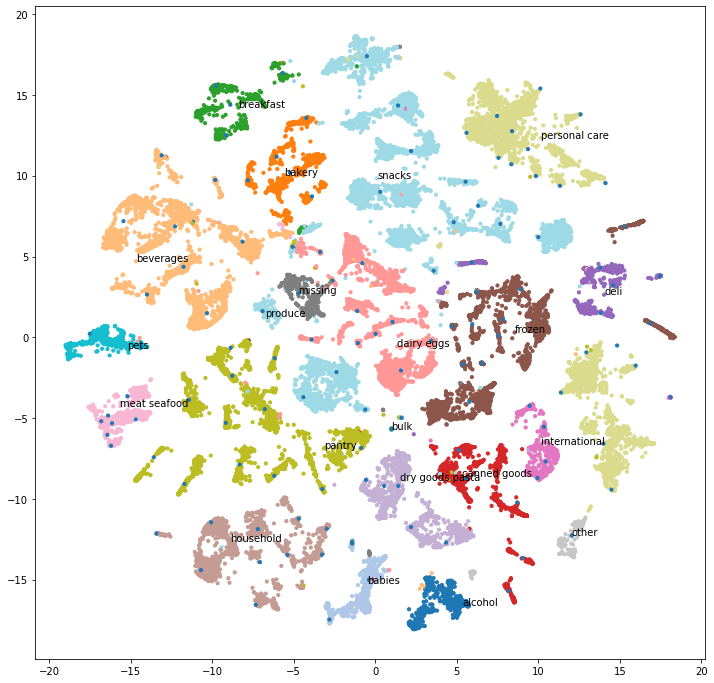

In [6]:
embeddings.visualize_embeddings(data_loader=data_loader, annotate_with="category_")

# Experiments

In [ ]:
product_to_key = {}
key_to_product = {}

for item_key, item_name in embeddings.product_key_conversion.items():
    product_to_key[item_name.split("\t")[0]] = item_key
    
key_to_product = {item_key: item_name for (item_name, item_key) in product_to_key.items()}

In [ ]:
calculation = (embeddings.model.wv[product_to_key["Organic Banana"]] - embeddings.model.wv[product_to_key["Banana"]]) + embeddings.model.wv[product_to_key["Fuji Apples"]] 

similar_by_vector = embeddings.model.wv.similar_by_vector(calculation, topn=20)

[(key_to_product[product_key], similarity) for product_key, similarity in similar_by_vector]

# Hyperparameter Search

In [ ]:
# We perform
# a hyperparameter search (300k models evaluated) on: the number of
# epochs n (10 to 200 with step of +10), the window-size L (3, 7, 12, 15),
# the sub-sampling parameter t (Eq. (2)) (10−5
# to 10−1 with step of ×10), the negative sampling distribution parameter α (Eq. (3)) (−1.4
# to 1.4 with step of +0.2), the embedding size (50 to 200 with a step
# of 50), the number of negative samples (5 to 20 with a step of 5) and
# the learning rate (0.0025 to 0.25 with a step of ×10). The marginal
# benefit of including the 3 latter variables to the optimization is not
# significant, with less than 2% in terms of performance. Thus, for
# readability, we only focus on the influence of the 4 first hyperparameters and keep the other fixed to default values (respectively
# 50, 5 and 0.025).

In [ ]:
# Baseline

# Most Popular 
# Hit Rate @ 10 on Validation Set: 0.0703 +/- 0.0006
# Hit Rate @ 10 on Test Set:       0.0709 +/- 0.0004
# NDCG @ 10 on Validation Set:     0.0389 +/- 0.0005
# NDCG @ 10 on Test Set:           0.039 +/- 0.0002

# Most Popular For User
# Hit Rate @ 10 on Validation Set: 0.3043 +/- 0.0008
# Hit Rate @ 10 on Test Set:       0.2804 +/- 0.0006
# NDCG @ 10 on Validation Set:     0.1693 +/- 0.0003
# NDCG @ 10 on Test Set:           0.1558 +/- 0.0005

# Item Co-Count

In [ ]:
epochs = [1]
window_sizes = [100, 200] # using 100 * metadata added. In this case I only added category which doubles the items in each sentence
samples = [0.01] # 0.01
ns_exponents = [0.5] # 0.5
embedding_sizes = [128]
numbers_of_negative_samples = [7]

k_neighbors = 10
k_predictions = 10

results = []

for epoch in epochs:
    for window_size in window_sizes:
        for sample in samples:
            for ns_exponent in ns_exponents:
                for embedding_size in embedding_sizes:
                    for number_of_negative_samples in numbers_of_negative_samples:
                        start = time.time()
                        print(f"Epoch: {epoch}, Window Size: {window_size}, Sample: {sample}, NS Exponent: {ns_exponent}, Embedding Size: {embedding_size}, Number of Negative Samples: {number_of_negative_samples}")

                        train_sentences = SentenceIterator(sentences_filepath=train_sentences_path)

                        # Train the model
                        model = train_model(
                                            train_sentences,
                                            epochs=epoch,
                                            embedding_size=embedding_size,
                                            window_size=window_size,
                                            min_count= 10,
                                            number_of_negative_samples=number_of_negative_samples,
                                            sample=sample,
                                            ns_exponent=ns_exponent,
                                            save=False,
                                        )
                        
                        model, embedding_vectors, context_vectors = get_filtered_model_vectors(model)

                        mapping = {item_key: index for index, item_key in enumerate(model.wv.index2word)}
                        mapping_back = {index: item_key for item_key, index in mapping.items()}
                        embedding = [model.wv[key] for key in mapping.keys()]

                        assert len(embedding) == len(mapping) == len(embedding_vectors) == len(context_vectors)
    
                        y_category_list = []
                        y_aisle_list = []

                        for key in mapping.keys():
                            y_category_list.append(product_key_to_meta(key).split("\t")[1])
                            y_aisle_list.append(product_key_to_meta(key).split("\t")[2])

                        assert len(embedding) == len(y_category_list) == len(y_aisle_list)

                        # K Neighbors Classifier
                        k_neighbors_classifier = KNeighborsClassifier(n_neighbors=k_neighbors, n_jobs=-1)

                        category_f1 = predict_labels(classifier=k_neighbors_classifier, x=embedding, y=y_category_list)
                        aisle_f1 = predict_labels(classifier=k_neighbors_classifier, x=embedding, y=y_aisle_list)

                        print(f"Category - Micro: {category_f1[0]}, Macro: {category_f1[1]}, Weighted: {category_f1[2]}")
                        print(f"Aisle    - Micro: {aisle_f1[0]}, Macro: {aisle_f1[1]}, Weighted: {aisle_f1[2]}")

                        # Recommender
                        metaitem2vec_recommender = Item2VecRecommender(algorithm="meta-item2vec", 
                                                                       item_key_mapping=mapping, 
                                                                       embedding_vectors=embedding_vectors, 
                                                                       context_vectors=context_vectors)

                        validation_auc, validation_ndcg = metaitem2vec_recommender.evaluate(validation_data)
                        print(f"AUC on Validation Set: {validation_auc}")
                        print(f"NDCG on Validation Set: {validation_ndcg}")

                        # test_auc, test_ndcg = metaitem2vec_recommender.evaluate(test_data)
                        # print(f"AUC on Test Set: {test_auc}")
                        # print(f"NDCG on Test Set: {test_ndcg}")

                        results.append((epoch, 
                                        window_size, 
                                        sample, 
                                        ns_exponent, 
                                        embedding_size,
                                        number_of_negative_samples,
                                        category_f1[0], 
                                        aisle_f1[0], 
                                        category_f1[1], 
                                        aisle_f1[1],
                                        category_f1[2], 
                                        aisle_f1[2],
                                        validation_auc, 
                                        validation_ndcg
                                       ))

                        with open('parameter_search.txt', 'w') as f:
                            for line in results:
                                f.write(f"{str(line)}\n")


                        end = time.time()
                        print(f"Took {end - start} seconds\n")

results.sort(key=lambda x: x[12], reverse=True)
results

In [ ]:
results.sort(key=lambda x: x[12], reverse=True)

In [ ]:
# Read
with open(f'results/{algorithm}_parameter_search.txt', 'r') as f:
    results = f.readlines()
    results = [eval(p.strip()) for p in results]

In [ ]:
results_df = pd.DataFrame(results, columns=[
                                            "Epoch", 
                                            "Window Size", 
                                            "Sample",
                                            "NS Exponent", 
                                            "Embedding Size", 
                                            "Number of Negative Samples",
                                            "F1 Macro Category",
                                            "F1 Macro Aisle",
                                            "F1 Micro Category",
                                            "F1 Micro Aisle",
                                            "Within-basket AUC",
                                            "Within-basket NDCG",
                                            "Within-basket Recall",
                                            "Within-basket Precision",
                                            "Next-basket AUC",
                                            "Next-basket NDCG",
                                            "Next-basket Recall",
                                            "Next-basket Precision"
                                          ])
results_df.to_csv(f'results/{algorithm}/{small}results.csv', index=False)

In [ ]:
# results_df = pd.read_csv(f'results/{algorithm}/{small}results.csv')
# results_df.sort_values("Sample", ascending=False)
column = "Sample"

print(results_df.groupby(column)[["Within-basket AUC", "Next-basket AUC", "Within-basket NDCG", "Next-basket NDCG", "Within-basket Recall", "Next-basket Recall"]].mean())
print("\n#########################\n")
print(results_df.groupby(column)[["Within-basket AUC", "Next-basket AUC", "Within-basket NDCG", "Next-basket NDCG", "Within-basket Recall", "Next-basket Recall"]].median())

In [ ]:
correlation = results_df.corr(method='spearman')
correlation.style.background_gradient(cmap='coolwarm')

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
results_df["Avg. Recall"] = (results_df["Within-basket Recall"] + results_df["Next-basket Recall"]) /2
results_df.sort_values("Avg. Recall", ascending=False)